# LANL Earthquake Prediction 

### Written by Anand
------------

## Data Description

The goal of this competition is to use acoustic seismic signals to predict the estimated time to laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, you should predict a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake

----------
The train.csv file is a humongous file with 629,145,480 rows and 2 columns(indicating `acoustic_data` and`time_to_failure` respectively). The file itself takes 8.89GB of hard-disk space, so it is very important not to load to it entirely.


The Dataset can be downloaded from  - https://www.kaggle.com/c/LANL-Earthquake-Prediction/data


In [1]:
import numpy as np
import pandas as pd
from time import time

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sklearn
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

# Custom DataProcessor
from dataprocess import DataProcessor, TestDataProcessor

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Print version Info
print("Numpy version: ",np.__version__)
print("Matplolib version: ",matplotlib.__version__)
print("Pandas version: ",pd.__version__)
print("Seaborn version: ",sns.__version__)
print("LightGBM version: ",lgb.__version__)
print("PyTorch version: ",torch.__version__)
print("Sklearn version: ",sklearn.__version__)

Numpy version:  1.16.2
Matplolib version:  3.0.3
Pandas version:  0.24.2
Seaborn version:  0.9.0
LightGBM version:  2.2.2
PyTorch version:  1.0.1
Sklearn version:  0.20.3


## Data Pre-processing
 I have written a custom pre-processor to handle the data in batches and preprocess. Note that the data is **Huge** it is impractical to read all the data and load it unto the RAM. It is also a poor coding practice. This data processor never loads the entire raw data, and uses the iterator to read data in batches and process it. The `DataProcessor` also has some inbuilt plotting functions to visualize the data.
 
 First, let's start with plotting the raw data sample.

In [3]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

DATA_PATH = "D:/Jobs/Incubit/" # Path to the extracted data from the file "LANL-Earthquake-Prediction.zip"
TEST_DATA_PATH = "D:/Jobs/Incubit/test/"
SAVE_MODEL_PATH = "D:/Jobs/Incubit/Code/saved_models/" # Path to save the learned models

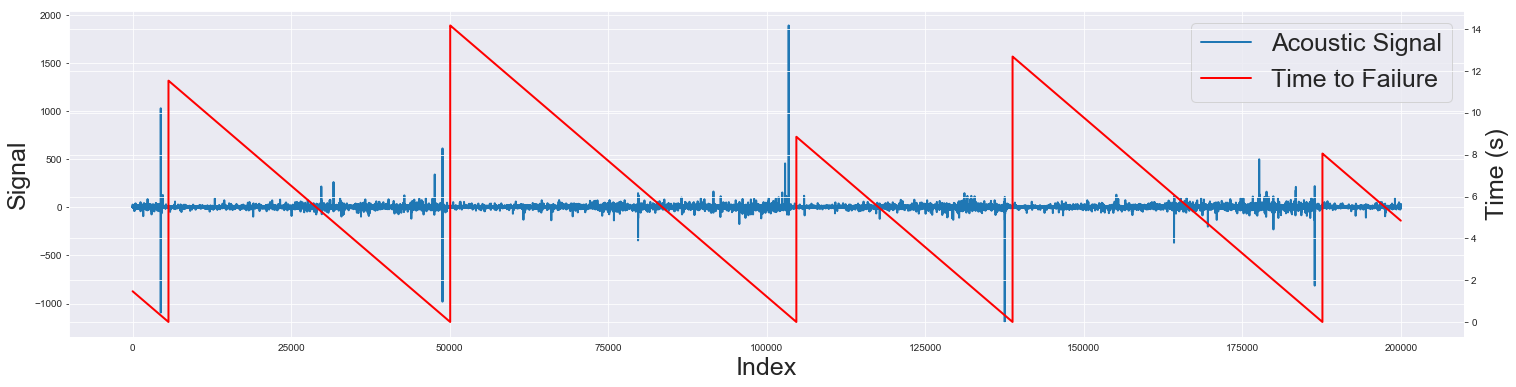

In [4]:
dl = DataProcessor("train.csv", DATA_PATH, 120)

dl.plot_data_sample()

By zooming in the data, we see that the `time_to_failure`signal has some kind of step-like structure. This essentially indicates the resolution of the device measuring the time. Let's plot the resolution of the data. Also, note that there is a lag between the peaks in the acoustic data and the actualy failure time.

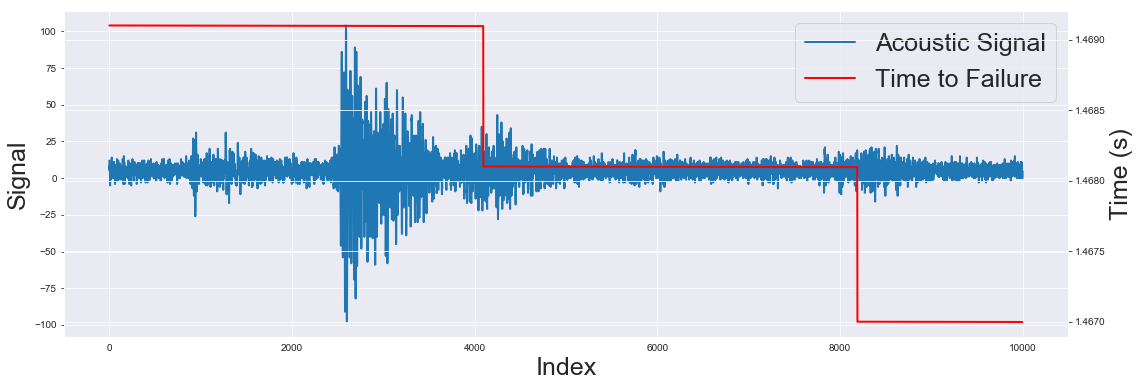

In [5]:
dl.plot_resolution()

Clearly, the `time_to_failure` doesn't change continuously with the acoustic signal. Therefore, my first idea was to compress the signal within this resolution. We can assume that the acoustic signal has some Gaussian noise (usualy assumption) and replace the signal within this resolution time with some *sufficient statistic* without any loss of the data information. This is done by the `resolve_data` function for which two commonly used sufficient statistics can be used - *mean* or *z-score*.

In [6]:
print("Resolution in time_to_failure : {}".format(dl._find_resolution()))
dl.resolve_data(summary_stats = 'mean')

Resolution in time_to_failure : 4096
Pre-resolved data already available!


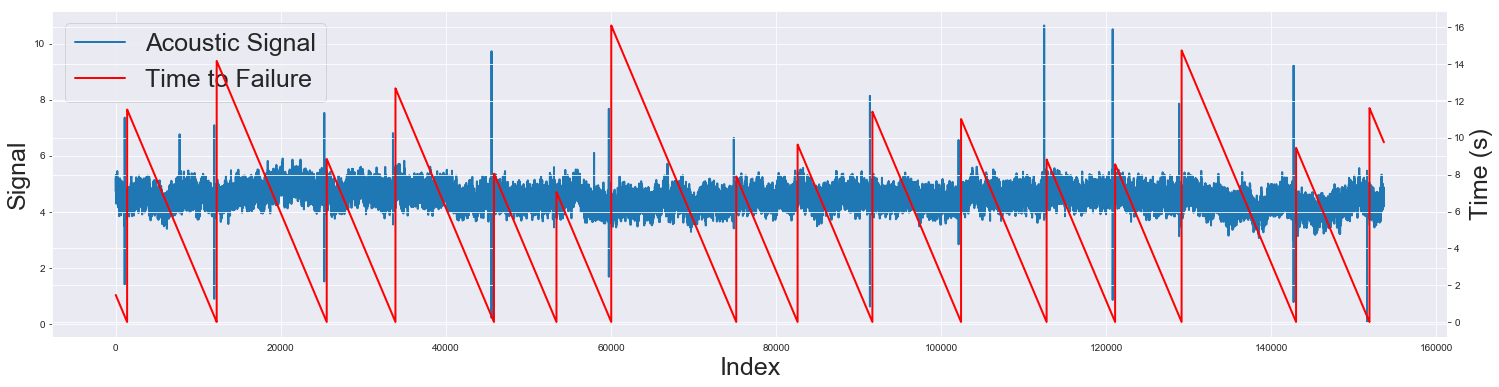

In [7]:
# Let's plot the data again!
dl.plot_data_sample()

In [8]:
dl.resolve_data_summary()

       acoustic_data  time_to_failure
count  153638.000000    153638.000000
mean        4.519468         5.678306
std         0.326239         3.672431
min         0.078632         0.000349
25%         4.305495         2.626201
50%         4.521368         5.349832
75%         4.737241         8.173265
max        10.647375        16.107043


Since, we have compressed the original data, the resolved_train data contains only 153,639 rows and 2 columns. This takes just 5.27MB!!! This can easily be loaded onto the memory without any problem. Furthermore, the peaks in the acoustic signal and the failure are almost at the same time. We shall use this dataset with a sliding window for our Sequence model using LSTM.

### Feature Extraction
Another way to process the data is use simply use a batch of sufficient length and try to extract useful statistics like mean, standard deviation, quantiles, etc. This list of features can be huge and we can simply let the model to choose what features are important.
Also note that the previous data pre-processing is essentially the same idea with batch length = 4096 and the statistic to be the mean/z-score.

As such, we shall borrow the knowledge of feature extraction from other kagglers from other competitions. I have added few of the features from my knowledge - feaquency-based features (since, it is a signal) and norm-based features. I have grouped the features in the following categrories as follows -

- **Moment features**- Mean, Standard Deviation, Skew and Kurtosis (just the first four moments of the data)
- **Quantile features** - 1%, 5%, 95%,99% quantiles, median, minimum, F-test, average abolute change
- **Frequencey features**- mean absolute DCT, max absolute DCT, min absolute DCT, 5%, 25%, 75%, 95% quantiles
- **Norm feature**- max norm, 2nd norm, 3rd norm

Furthermore, we also use a sliding window within each batch to capture the local relations. Again, we take the statistical features such as mean, quantiles etc.

In [9]:
features = ['moment','quantile','freq', 'norm', 'subwindow']
dl.extract_features(features, N = 150_000) # Batch size of 150,000 

Feature extracted data already available!


In [10]:
# Let's similarly extract the features for the test data
tl = TestDataProcessor(DATA_PATH + 'sample_submission.csv',TEST_DATA_PATH )
tl.resolve_data()
tl.extract_features(features)

Pre-resolved data already available!
Feature extracted data already available!


In [11]:
X_t = tl.get_resolved_test_data()
X_t.shape

(37, 102)

In [12]:
X_tr, y_tr = dl.get_feature_data()

# Sanity check for Nans etc
X_tr.isnull().sum()

ave                             0
std                             0
kurt                            0
skew                            0
min                             0
q01                             0
q05                             0
q95                             0
q99                             0
abs_median                      0
abs_q95                         0
abs_q99                         0
av_change_abs                   0
mean-abs-DCT                    0
max-abs-DCT                     0
min-abs-DCT                     0
q-DCT-0.05                      0
q-DCT-0.95                      0
q-DCT-0.25                      0
q-DCT-0.75                      0
max                             0
max-abs                         0
norm-2                          0
norm-3                          0
ave_roll_std_10                 0
std_roll_std_10                 0
max_roll_std_10                 0
min_roll_std_10                 0
q01_roll_std_10                 0
q05_roll_std_1

In [13]:
#Train head

X_tr.head()

,ave,std,kurt,skew,min,q01,q05,q95,q99,abs_median,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101089,33.661319,-0.024061,-98.0,-8.0,-2.0,11.0,18.0,5.0,...,4.883418,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,5.629
1,4.725767,6.588802,98.755185,0.390557,-154.0,-11.0,-2.0,12.0,21.0,5.0,...,4.724876,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002,5.667
2,4.906393,6.967374,33.554053,0.217388,-106.0,-15.0,-3.0,13.0,26.0,5.0,...,4.905840,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,0.000001,5.957
3,4.902240,6.922282,116.544247,0.757270,-199.0,-12.0,-2.0,12.0,22.0,5.0,...,4.901486,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-0.000003,5.858
4,4.908720,7.301086,52.976099,0.064530,-126.0,-15.0,-2.0,12.0,26.0,5.0,...,4.910196,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,0.000002,6.078


In [14]:
X_ts = tl.get_test_feature_data()

#Sanity chgeck for test data
X_ts.isnull().sum()

ave                             0
std                             0
kurt                            0
skew                            0
min                             0
q01                             0
q05                             0
q95                             0
q99                             0
abs_median                      0
abs_q95                         0
abs_q99                         0
av_change_abs                   0
mean-abs-DCT                    0
max-abs-DCT                     0
min-abs-DCT                     0
q-DCT-0.05                      0
q-DCT-0.95                      0
q-DCT-0.25                      0
q-DCT-0.75                      0
max                             0
max-abs                         0
norm-2                          0
norm-3                          0
ave_roll_std_10                 0
std_roll_std_10                 0
max_roll_std_10                 0
min_roll_std_10                 0
q01_roll_std_10                 0
q05_roll_std_1

In [15]:
#Test head

X_ts.head()

,ave,std,kurt,skew,min,q01,q05,q95,q99,abs_median,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.491780,4.893673,28.836567,0.327904,-75.0,-8.0,-2.0,11.0,18.0,5.0,...,4.491468,0.231891,5.495,3.774,3.889,4.099,4.867,5.000,1.778523e-06,5.495
1,4.171153,5.922820,56.217041,0.295705,-140.0,-12.0,-2.0,11.0,20.0,4.0,...,4.173633,0.230914,5.009,3.342,3.644,3.790,4.541,4.739,-1.946309e-07,5.009
2,4.610260,6.946967,162.112840,0.428684,-193.0,-11.0,-2.0,11.0,20.0,5.0,...,4.612455,0.247219,6.234,3.544,4.013,4.215,4.966,5.082,8.053691e-08,6.234
3,4.531473,4.114133,41.240413,0.061889,-93.0,-5.0,-1.0,10.0,14.0,5.0,...,4.532571,0.224909,5.446,3.889,4.032,4.184,4.911,5.051,3.899329e-06,5.446
4,4.128340,5.797144,79.537016,0.073898,-147.0,-10.0,-2.0,10.0,19.0,4.0,...,4.125805,0.274025,5.027,3.357,3.534,3.662,4.570,4.870,-2.939597e-06,5.027


## Machine Learning Approach

Now, with processed data and extracted features, it is time to run some models on the data and see their performance. First, I shall use kernel ridge regression, which is essentially a generalised linear regression but with some non-linear transformations of the data. However, fine-tuning the parameters are often difficult. Therefore, I shall use grid search to search for the optimal hyper parameters with K-fold cross validation. Another important thing to keep in mind is that, the evaluation metric used is `MAE` (Mean Absolute Error). Therefore, it is crucial that we optimize to reduce this error rather than some arbitrary metric.

In [16]:
def grid_search_cv(model, grid, features, target,num_folds = 5):
    """
    Search for the optimal hyperparameter-combination in the given grid.
    """
    start_time = time()
    reggressor = GridSearchCV(model, grid, cv=num_folds, scoring='neg_mean_absolute_error')
    reggressor.fit(features, target)
    
    end_time = time() - start_time
    print("Best CV score: {:.3f}, time: {:.2f}s".format(-reggressor.best_score_, end_time))
    print("Best hyperparameters :", reggressor.best_params_)
    return reggressor.best_params_

def model_predict(model, features, target,num_folds = 5, test=None, plot=True, lgb=False):
    """
    Train the estimator and make predictions for oof and test data.
    """
    folds = KFold(num_folds, shuffle=True)
    oof_predictions = np.zeros(features.shape[0])
    if test is not None:
        sub_predictions = np.zeros(test.shape[0])
        
    for (train_index, valid_index) in folds.split(features, target):
        
        if lgb:
            model.fit(features[train_index], target[train_index],
                          early_stopping_rounds=100, verbose=False,
                          eval_set=[(features[train_index], target[train_index]),
                                    (features[valid_index], target[valid_index])])
        else:
            model.fit(features[train_index], target[train_index])
            
        oof_predictions[valid_index] = model.predict(features[valid_index]).flatten()
        if test is not None:
            sub_predictions += model.predict(test).flatten() / num_folds
    
    # Plot out-of-fold predictions (oof) vs actual values (Code taken from a Kaggle kernel)
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual',fontsize=15)
        ax1.set_ylabel('predicted',fontsize=15)
        ax2.set_xlabel('train index',fontsize=15)
        ax2.set_ylabel('time to failure',fontsize=15)
        ax1.scatter(target, oof_predictions, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
        ax2.plot(target, color='blue', label='Actual')
        ax2.plot(oof_predictions, color='orange',label = 'Predictions')
        plt.legend(fontsize=15)
    if test is not None:
        return oof_predictions, sub_predictions
    else:
        return oof_predictions, model

Best CV score: 2.231, time: 124.87s
Best hyperparameters : {'alpha': 0.1, 'gamma': 0.01111112}


['D:/Jobs/Incubit/Code/saved_models/kernelridge.pkl']

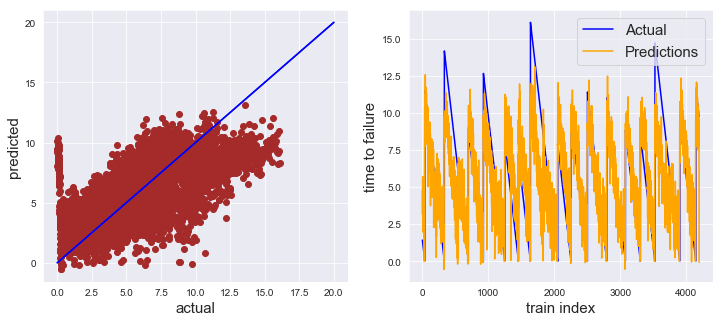

In [17]:
# Kernel Ridge Regression
scaler = StandardScaler() # Z-score normalize the data features
X_train_scaled = scaler.fit_transform(X_tr)
target = y_tr.values.flatten()
num_folds = 5

# We essentially optimize over the gamma parameter of the rbf kernel and the scaling alpha
grid = [{'gamma': np.linspace(1e-8, 0.1, 10), 'alpha': [0.0005, 0.001, 0.02, 0.08, 0.1]}]

params = grid_search_cv(KernelRidge(kernel='rbf'), grid, X_train_scaled, target)
kr_oof, kridge_model = model_predict(KernelRidge(kernel='rbf', **params), X_train_scaled, target)


# Save trained model
joblib.dump(kridge_model, SAVE_MODEL_PATH+'kernelridge.pkl') 

In [18]:
# Predict the values on the test data
X_test_scaled = scaler.fit_transform(X_ts)
kridge_model.predict(X_test_scaled).flatten()

array([3.43125588, 5.46363022, 6.89980478, ..., 3.09748849, 1.29347799,
       8.49322597])

Now, I shall test on the famous time-tested gradient-boosted decision trees. For this I shall use the lightGBM python library. Once again, I shall use gridsearch with k-fold cross validation to search for the optimal hyper-parameters for this model.

Performing randomsearch CV on LightGBM Model...



Best mean score: 2.0240, num rounds: 100
Best hyperparameters :  {'learning_rate': 0.05, 'min_gain_to_split': 0.01, 'lambda_l1': 0.4, 'lambda_l2': 0.2, 'num_leaves': 24, 'max_depth': 6, 'feature_fraction': 1.0, 'min_data_in_leaf': 100, 'subsample': 0.85, 'objective': 'regression_l1', 'boosting': 'gbdt', 'verbosity': -1, 'random_seed': 489, 'num_boosting_round': 20000, 'tree_learner': 'data_parallel'}


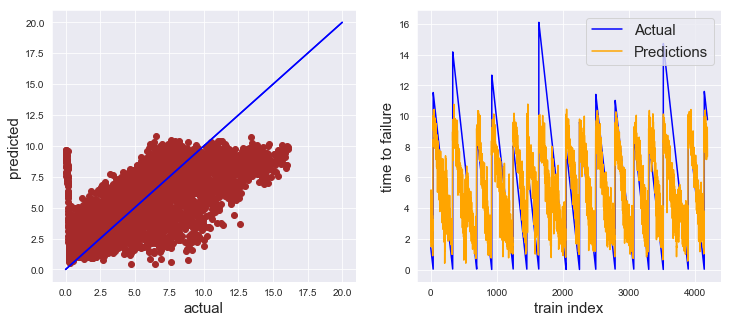

In [19]:
fixed_params = {
    'objective': 'regression_l1',
    'boosting': 'gbdt', #'dart'
    'verbosity': -1,
    'random_seed': 489,
    'num_boosting_round': 20000, # Num learners
    'tree_learner':'data_parallel',
}

param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9], # L1 regularizer
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9], # L2 regularizer
    'num_leaves': list(range(16, 80, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1], 
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
}

best_score = np.inf # Max-out the best score for comparison
dataset = lgb.Dataset(X_tr, label=y_tr) 

print("Performing randomsearch CV on LightGBM Model...")
for i in tqdm_notebook(range(100)):
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params, dataset, nfold=5, early_stopping_rounds=100, stratified=False)
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params
        best_nrounds = len(result['l1-mean'])
        
print("Best mean score: {:.4f}, num rounds: {}".format(best_score, best_nrounds))
print("Best hyperparameters : ",best_params)

gb_oof, lgbm_model =  model_predict(lgb.LGBMRegressor(**best_params), X_tr.values, y_tr.values.flatten(), lgb=True)

lgbm_model.predict(X_test_scaled).flatten()
lgbm_model.booster_.save_model(SAVE_MODEL_PATH+'lgbm.pkl')

In [20]:
# Load Model
lgbm_model = lgb.Booster(model_file=SAVE_MODEL_PATH+'lgbm.pkl')

#Predict the time to failure values on the test data
lgbm_model.predict(X_test_scaled).flatten()

array([9.02863151, 9.15696771, 9.33259722, ..., 8.90189291, 5.18134737,
       9.57256597])

## Deep Learning Approach I - Neural Network Prediction
The first approaxh was to use a simple fully-connected feedforward network as a regressor model over the extracted features. As such, I created a simple 3-layer network for this task. I didnt have to create a data loader since the dataset is small enough and pandas provide a nice litte iterator that can be used as a dataloader.

In [21]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, p):
        super(NeuralNet, self).__init__()
        self.hidden_1 = nn.Linear(n_feature, 220)
        self.bn1 = nn.BatchNorm1d(220)
        
        self.hidden_2 = nn.Linear(220, 140)
        self.bn2 = nn.BatchNorm1d(140)
        
        self.hidden_3 = nn.Linear(140, 10)
        self.bn3 = nn.BatchNorm1d(10)
        
        #self.hidden_4 = nn.Linear(n_hidden, 40)
        
        self.predict = nn.Linear(10, n_output)
        self.dropout = nn.Dropout(p)
        

    def forward(self, x):
        x = torch.tanh(self.dropout(self.bn1(self.hidden_1(x))))
        x = torch.tanh(self.bn2(self.hidden_2(x)))
        x = F.relu(self.bn3(self.hidden_3(x)))
        #x = F.relu(self.hidden_4(x))
        x = self.predict(x)
        return x
    

In [22]:
batchsize = 30
X_tr, y_tr = dl.get_feature_data()

net = NeuralNet(n_feature=X_tr.shape[1], n_hidden=400, n_output=1, p = 0.7)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.L1Loss()

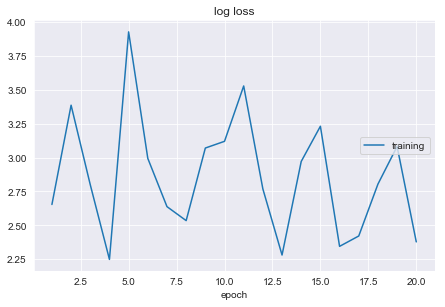

log loss:
training   (min:    2.249, max:    3.928, cur:    2.378)


In [23]:
liveloss = PlotLosses()

N_epoch = 20
net.train()
for epoch in range(N_epoch):
    logs = {}

    running_loss = 0.0

    for i in range(X_tr.shape[0]//batchsize):
        inds = np.random.choice(X_tr.shape[0], batchsize, replace=False)

        x = torch.from_numpy(X_tr.iloc[inds,:].values).type('torch.FloatTensor')
        y = torch.from_numpy(y_tr.iloc[inds,:].values).type('torch.FloatTensor')
        prediction = net(x)     # forward pass
        #print(y)
        loss = loss_func(prediction, y)    

        optimizer.zero_grad()   
        loss.backward()         # backprop
        optimizer.step()  

        running_loss = loss.detach()

    epoch_loss = running_loss

    prefix = ''
    logs[prefix + 'log loss'] = epoch_loss.item()

    liveloss.update(logs)
    liveloss.draw()

torch.save(net.state_dict(), SAVE_MODEL_PATH+"NN_model.pth")

In [24]:
net.eval()
X_test = torch.from_numpy(X_ts.values).type('torch.FloatTensor')
net(X_test)

tensor([[7.5861],
        [6.3855],
        [6.2128],
        ...,
        [6.3856],
        [4.4293],
        [6.7095]], grad_fn=<AddmmBackward>)

## Deep Learning Approach II - Sequence Modeling
Alternatively, I thought of using a simple LSTM model to learn the sequence from the pre-processed data. The input is the acoustic signal and the target the time_to_failure signal. For this, I used a simply LSTM-based squence model with 3 layers of LSTMs. A custom dataloader (simple enough) had to be written for the sequnce model so that instead of just batches of data, we get a batch of sliding-window data. Where the data slides through a fixed window length to predict the next term in the sequence.

In [25]:
class Time_Series_Data(Dataset):

    def __init__(self, train_x, train_y):
        self.X = train_x
        self.y = train_y       

    def __getitem__(self, item):
        x_t = self.X[item]
        y_t = self.y[item]
        return x_t, y_t

    def __len__(self):
        
        return len(self.X)

# Sliding Window
def sliding_window_samples(X_train, y_train, lookBack = 36, RNN=True):

    dataX, dataY = [], []
    for i in range(len(X_train) - lookBack):
        sample_X = X_train[i:(i + lookBack)]
        sample_Y = y_train[i + lookBack]
        dataX.append(sample_X)
        dataY.append(sample_Y)
    dataX = np.array(dataX) 
    dataY = np.array(dataY) 

    if not RNN:
        dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1]))

    return dataX, dataY

Here, I shall use bidirectional LSTM with the intuition that information from the acoustic signal before and after a certain time prediction might have more information about the time value itself.

In [26]:
class SequenceModel(nn.Module):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, BiDir = False):
        super(SequenceModel, self).__init__()
        
        self.hiddenNum = hiddenNum
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.layerNum = layerNum
        self.BiDir = BiDir
        
        self.cell = nn.LSTM(input_size=self.inputDim, hidden_size=self.hiddenNum,
                               num_layers=self.layerNum, dropout=0.2,
                               batch_first=True,  bidirectional=True)
        """
        Using Bidirectional LSTM 'may' provide a better understanding of the acoustic signal?
        As it moves forward and backward through time, it can capture the information that is 
        conditioned upon the future values.        
        """
        self.fc = nn.Linear(self.hiddenNum, self.outputDim)

    def forward(self, x):        
        batchSize = x.size(0)
        if self.BiDir:
            h0 = Variable(torch.zeros(self.layerNum * 2, batchSize, self.hiddenNum)).cuda()
            c0 = Variable(torch.zeros(self.layerNum * 2, batchSize, self.hiddenNum)).cuda()
        else:
            h0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum)).cuda()
            c0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum)).cuda()           
        #print(x.size(), h0.size())
        rnnOutput, hn = self.cell(x, (h0, c0))
        out = rnnOutput.transpose(0,1).contiguous().view(-1, self.hiddenNum)
        fcOutput = self.fc(out)

        return fcOutput

In [27]:
# Create data pipeline for the sequence model
data = dl.get_resolved_data()
Num_train = int(0.8*data.shape[0])
Num_test = data.shape[0] - Num_train
X_train = data.values[:Num_train,0]
y_train = data.values[:Num_train,1]

X_test = data.values[:Num_test,0]
y_test = data.values[:Num_test,1]


lag = 36
flag = False
trainX, trainY = sliding_window_samples(X_train, y_train, lag, RNN=True)
train_dataset = Time_Series_Data(trainX, trainY)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, sampler=None, batch_sampler=None, num_workers=0)

testX, testY = sliding_window_samples(X_test, y_test, lag, RNN=True)
test_dataset = Time_Series_Data(testX, testY)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, sampler=None, batch_sampler=None, num_workers=0)

# DO NOT CHANGE THE num_workes PARAMETER!!. PyTorch Doesn't support Windows fully yet!!

In [28]:
checkPoint= 500
epoch = 4
hidden_num=64
input_dim = 1

seq_model = SequenceModel(inputDim=1, hiddenNum=hidden_num, outputDim=1, layerNum=3, BiDir = True).cuda()
optimizer = optim.SGD(seq_model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.MSELoss()        
train_loss_list, test_loss_list = [],[]

liveloss = PlotLosses()
start_time = time()
for i in range(epoch):
    for batch_idx, (x, y) in enumerate(trainloader):
        seq_model = seq_model.train()
        
        x= x.permute(1, 0).unsqueeze(2).float()
        x, y = Variable(x).cuda(), Variable(y.float()).cuda()
        optimizer.zero_grad()
        pred = seq_model(x)
        loss = criterion(pred, y)

        if batch_idx % checkPoint == 0 and batch_idx != 0:
            end_time = time() - start_time            
            
            with torch.no_grad():
                for x, y in testloader:
                    x= x.permute(1, 0).unsqueeze(2).float()
                    x, y = Variable(x).cuda(), Variable(y.float()).cuda()
                    pred = seq_model(x)
                    test_loss = criterion(pred, y)
            
            print("Epoch [{:3d}/{:3d}] Batch [{:4d}/{:4d}] [Train Loss: {:2.3f}] [Test Loss {:2.3f}] Time: {:.3f}s" .format(
                i, epoch, batch_idx, len(trainloader), loss.item(),test_loss.item(), end_time))
            
            train_loss_list.append(loss.item())            
            test_loss_list.append(test_loss.item())
            
#             logs[prefix + 'log loss'] = loss.item()

#             liveloss.update(logs)
#             liveloss.draw()
            
            start_time = time()

        loss.backward()
        optimizer.step()   
    print("-------------------------")

# torch.save(train_loss_list, "LSTM_train_loss.pth")
# torch.save(test_loss_list, "LSTM_test_loss.pth")
torch.save(seq_model.state_dict(), SAVE_MODEL_PATH+"Seq_model.pth")

Epoch [  0/  4] Batch [ 500/3840] [Train Loss: 14.062] [Test Loss 29.897] Time: 10.252s
Epoch [  0/  4] Batch [1000/3840] [Train Loss: 13.144] [Test Loss 2.217] Time: 9.745s
Epoch [  0/  4] Batch [1500/3840] [Train Loss: 12.487] [Test Loss 7.786] Time: 9.374s
Epoch [  0/  4] Batch [2000/3840] [Train Loss: 18.750] [Test Loss 17.773] Time: 9.453s
Epoch [  0/  4] Batch [2500/3840] [Train Loss: 12.012] [Test Loss 4.243] Time: 9.504s
Epoch [  0/  4] Batch [3000/3840] [Train Loss: 7.601] [Test Loss 31.855] Time: 10.016s
Epoch [  0/  4] Batch [3500/3840] [Train Loss: 7.300] [Test Loss 7.165] Time: 9.501s
-------------------------
Epoch [  1/  4] Batch [ 500/3840] [Train Loss: 12.607] [Test Loss 24.808] Time: 16.464s
Epoch [  1/  4] Batch [1000/3840] [Train Loss: 9.296] [Test Loss 36.241] Time: 9.837s
Epoch [  1/  4] Batch [1500/3840] [Train Loss: 17.956] [Test Loss 7.222] Time: 9.671s
Epoch [  1/  4] Batch [2000/3840] [Train Loss: 13.359] [Test Loss 11.457] Time: 9.673s
Epoch [  1/  4] Batch 